In [11]:
import requests
import gpxpy
import polyline
import pyproj

import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

In [42]:
def get_gpx_df(gpx_file):
    with open(gpx_file, 'r') as file:
        gpx = gpxpy.parse(file)

    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                })

    df = pd.DataFrame(data)

    df['prev_latitude'] = df['latitude'].shift(1)
    df['prev_longitude'] = df['longitude'].shift(1)
    
    g = pyproj.Geod(ellps='WGS84')
    
    df['fwd_azimuth'] = df.apply(
        lambda x: g.inv(x['prev_longitude'], x['prev_latitude'], x['longitude'], x['latitude'])[0] if not pd.isna(x['prev_latitude']) and not pd.isna(x['prev_longitude']) else 0, 
        axis=1,
    )
    df['fwd_azimuth'] = df['fwd_azimuth'].apply(lambda x: x + 360 if x < 0 else x)
    
    df['fwd_azimuth_delta'] = df['fwd_azimuth'].diff()
    
    df = df.drop(columns=[
        'prev_latitude', 
        'prev_longitude',
        'fwd_azimuth'
    ])
    
    return df

In [43]:
def get_route(points):
    params = {
        'geometries': 'polyline6',
    }
    response = requests.get(f"http://127.0.0.1:6000/route/v1/foot/{points}", params=params)
    response.raise_for_status()
    routes = response.json()
    return polyline.decode(routes['routes'][0]['geometry'], 6)

In [44]:
def get_nearest(coords):
    lat, lon = coords
    response = requests.get(f"http://127.0.0.1:6000/nearest/v1/foot/{lon},{lat}")
    response.raise_for_status()
    waypoints = response.json()
    location = waypoints['waypoints'][0]['location']
    return f"{location[0]},{location[1]}"

In [45]:
def plot_gpx(df):
    plt.figure(figsize=(10, 10))
    plt.plot(df['longitude'], df['latitude'], color='red', label='Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()

In [46]:
df = get_gpx_df('../data/garmin.gpx')
df.head()

,latitude,longitude,fwd_azimuth_delta
0,1.309403,103.896450,NaN
1,1.309681,103.896458,1.722692
2,1.309693,103.896455,345.022490
3,1.309507,103.896450,-165.211584
4,1.309467,103.896446,4.545150


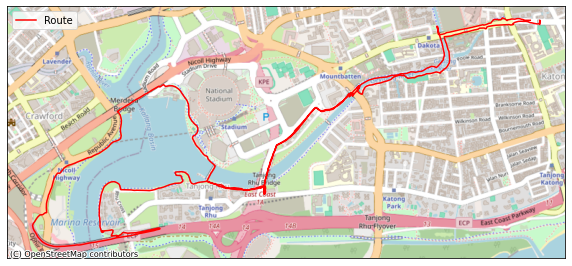

In [60]:
plot_gpx(df)

In [55]:
df.shape

(1047, 3)

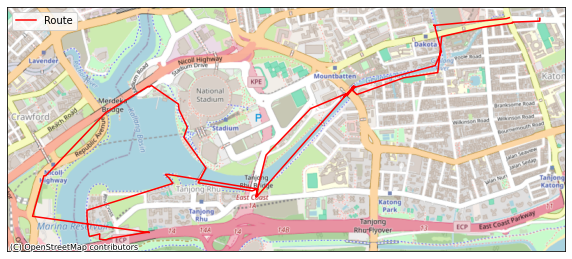

In [58]:
turns_df = df[abs(df['fwd_azimuth_delta']) >= 45]
plot_gpx(turns_df)

In [59]:
turns_df.shape

(85, 3)

In [61]:
points = list(turns_df[['latitude', 'longitude']].to_records(index=False))
print(points)

[(1.30969299, 103.89645517), (1.30950708, 103.89645022), (1.30943877, 103.89461417), (1.30939786, 103.89463604), (1.30940063, 103.89463454), (1.30937523, 103.89456614), (1.30910416, 103.89269647), (1.30847217, 103.88986649), (1.30604192, 103.88959877), (1.30604435, 103.88954437), (1.30569675, 103.88731202), (1.30457668, 103.88416646), (1.30484842, 103.88387469), (1.30510792, 103.88402254), (1.30449696, 103.88350069), (1.30460895, 103.88356556), (1.30464499, 103.88352768), (1.29771559, 103.87743764), (1.29778859, 103.87747795), (1.29820148, 103.87750335), (1.29820526, 103.87739556), (1.29810149, 103.87713295), (1.29864782, 103.87350485), (1.29964158, 103.87402486), (1.3017016, 103.87254286), (1.3023942, 103.87277386), (1.30354193, 103.87222535), (1.30357118, 103.87222208), (1.30378274, 103.87219467), (1.3038612, 103.87219065), (1.30390302, 103.87218763), (1.30392549, 103.87218545), (1.30517934, 103.87036566), (1.30508269, 103.8702033), (1.30512586, 103.87014798), (1.30336373, 103.867296

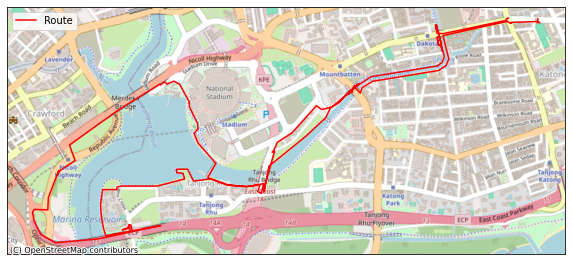

In [62]:
route_points = ';'.join(map(get_nearest, points))

route = get_route(route_points)
osrm_df = pd.DataFrame(route, columns=['latitude', 'longitude'])

plot_gpx(osrm_df)